Initial Shape: (19237, 18)
Shape After Outlier Removal: (18164, 18)

===== EDA REPORT =====
Total Cars: 18164
Average Price: 14024.92
Median Price: 12231.0
Most Common Manufacturer:
 Manufacturer
TOYOTA           3558
HYUNDAI          3460
MERCEDES-BENZ    1905
FORD             1056
CHEVROLET        1043
Name: count, dtype: int64
Fuel Type Distribution:
 Fuel type
Petrol            9499
Diesel            3667
Hybrid            3534
LPG                885
CNG                494
Plug-in Hybrid      84
Hydrogen             1
Name: count, dtype: int64


C:\Users\shubh\AppData\Local\Temp\ipykernel_13448\3424863641.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


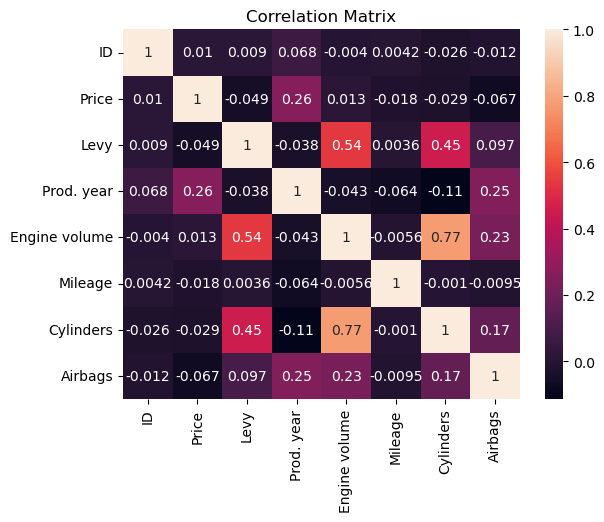


===== MODEL PERFORMANCE =====
Linear Regression R²: 0.3797
Random Forest R²: 0.7837

Top 10 Most Important Features:
                      Feature  Importance
2                  Prod. year    0.215060
0                          ID    0.088605
4                     Mileage    0.081327
6                     Airbags    0.080530
1575         Fuel type_Diesel    0.073610
3               Engine volume    0.068978
1                        Levy    0.062504
1582  Gear box type_Tiptronic    0.059989
5                   Cylinders    0.024078
1574     Leather interior_Yes    0.021942


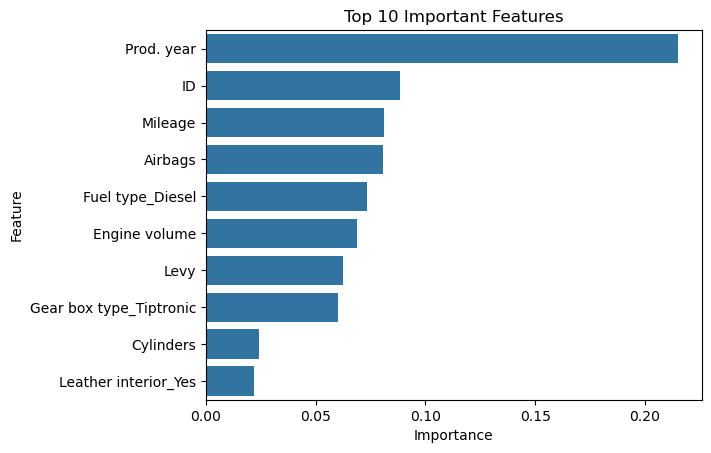


🚀 PIPELINE COMPLETED SUCCESSFULLY


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

file_path = "C:\\Users\\shubh\\OneDrive\\Desktop\\intern\\week 3\\day 3\\car_price_prediction.csv"
df = pd.read_csv(file_path)

print("Initial Shape:", df.shape)

df['Levy'] = df['Levy'].replace('-', np.nan)
df['Levy'] = pd.to_numeric(df['Levy'], errors='coerce')

df['Mileage'] = df['Mileage'].str.replace(' km', '', regex=False)
df['Mileage'] = pd.to_numeric(df['Mileage'], errors='coerce')

df['Engine volume'] = df['Engine volume'].str.replace(' Turbo', '', regex=False)
df['Engine volume'] = pd.to_numeric(df['Engine volume'], errors='coerce')

for col in df.select_dtypes(include=np.number).columns:
    df[col].fillna(df[col].median(), inplace=True)

Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df = df[(df['Price'] >= lower) & (df['Price'] <= upper)]

print("Shape After Outlier Removal:", df.shape)
print("\n===== EDA REPORT =====")
print("Total Cars:", df.shape[0])
print("Average Price:", round(df['Price'].mean(), 2))
print("Median Price:", round(df['Price'].median(), 2))
print("Most Common Manufacturer:\n", df['Manufacturer'].value_counts().head(5))
print("Fuel Type Distribution:\n", df['Fuel type'].value_counts())

plt.figure()
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True)
plt.title("Correlation Matrix")
plt.show()

X = df.drop('Price', axis=1)
y = df['Price']

X = pd.get_dummies(X, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
r2_lr = r2_score(y_test, y_pred_lr)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)

print("\n===== MODEL PERFORMANCE =====")
print("Linear Regression R²:", round(r2_lr, 4))
print("Random Forest R²:", round(r2_rf, 4))

importances = rf.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

plt.figure()
sns.barplot(x='Importance', y='Feature',
            data=importance_df.head(10))
plt.title("Top 10 Important Features")
plt.show()

print("\n🚀 PIPELINE COMPLETED SUCCESSFULLY")

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# -----------------------------
# LOAD DATA
# -----------------------------
file_path = "C:\\Users\\shubh\\OneDrive\\Desktop\\intern\\week 3\\day 3\\car_price_prediction.csv"
df_original = pd.read_csv(file_path)

print("Original Shape:", df_original.shape)

# -----------------------------
# CLEAN NUMERIC COLUMNS
# -----------------------------
def clean_data(df):
    df = df.copy()

    df['Levy'] = df['Levy'].replace('-', np.nan)
    df['Levy'] = pd.to_numeric(df['Levy'], errors='coerce')

    df['Mileage'] = df['Mileage'].str.replace(' km', '', regex=False)
    df['Mileage'] = pd.to_numeric(df['Mileage'], errors='coerce')

    df['Engine volume'] = df['Engine volume'].str.replace(' Turbo', '', regex=False)
    df['Engine volume'] = pd.to_numeric(df['Engine volume'], errors='coerce')

    return df

df_original = clean_data(df_original)

# =====================================================
# 🔥 PART 1: COMPARE BEFORE vs AFTER NULL REMOVAL
# =====================================================

print("\nMissing Values BEFORE:", df_original.isnull().sum().sum())

df_dropna = df_original.dropna()
print("Shape AFTER dropna():", df_dropna.shape)

df_fill = df_original.copy()
for col in df_fill.select_dtypes(include=np.number).columns:
    df_fill[col].fillna(df_fill[col].median(), inplace=True)

for col in df_fill.select_dtypes(include='object').columns:
    df_fill[col].fillna(df_fill[col].mode()[0], inplace=True)

print("Shape AFTER fillna():", df_fill.shape)

# We will continue using df_fill (better practice)
df = df_fill

# =====================================================
# 🔥 PART 2: LOG TRANSFORMATION (Handle Skewness)
# =====================================================

print("\nPrice Skewness BEFORE log:", df['Price'].skew())

df['Price'] = np.log1p(df['Price'])

print("Price Skewness AFTER log:", df['Price'].skew())

# =====================================================
# 🔥 PART 3: OUTLIER REMOVAL
# =====================================================

Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

df = df[(df['Price'] >= Q1 - 1.5*IQR) &
        (df['Price'] <= Q3 + 1.5*IQR)]

print("Shape After Outlier Removal:", df.shape)

# =====================================================
# 🔥 PART 4: PREPROCESSING
# =====================================================

X = df.drop('Price', axis=1)
y = df['Price']

X = pd.get_dummies(X, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# =====================================================
# 🔥 PART 5: CROSS VALIDATION
# =====================================================

rf = RandomForestRegressor(random_state=42)

cv_scores = cross_val_score(rf, X_scaled, y,
                            cv=5, scoring='r2')

print("\nCross Validation R² Scores:", cv_scores)
print("Average CV R²:", cv_scores.mean())

# =====================================================
# 🔥 PART 6: RANDOM FOREST TUNING
# =====================================================

param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [20, 30, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)

grid.fit(X_scaled, y)

print("\nBest Parameters:", grid.best_params_)
print("Best Cross-Validated R²:", grid.best_score_)

best_rf = grid.best_estimator_

# =====================================================
# 🔥 PART 7: FINAL TRAIN TEST PERFORMANCE
# =====================================================

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

final_r2 = r2_score(y_test, y_pred)

print("\nFINAL TEST R²:", round(final_r2, 4))

print("\n🚀 ADVANCED PIPELINE COMPLETED")


Original Shape: (19237, 18)

Missing Values BEFORE: 5819
Shape AFTER dropna(): (13418, 18)
Shape AFTER fillna(): (19237, 18)

Price Skewness BEFORE log: 136.4704265426872
Price Skewness AFTER log: -1.3757413681328339
Shape After Outlier Removal: (17177, 18)


C:\Users\shubh\AppData\Local\Temp\ipykernel_18896\4213818898.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_fill[col].fillna(df_fill[col].median(), inplace=True)
C:\Users\shubh\AppData\Local\Temp\ipykernel_18896\4213818898.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy


Cross Validation R² Scores: [0.79778831 0.80117184 0.83728188 0.82176847 0.8198991 ]
Average CV R²: 0.8155819202306992


KeyboardInterrupt: 